<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

**Цель проекта:**

Обучить модель кассификации комментариев на позитивные и негативные со значением метрики *F1* не менее 0,75. 

## Подготовка

Первоначально загрузим необходимые нам в работе библиотеки.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import spacy
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

Теперь загрузим датасет и взглянем на общие данные.

In [2]:
try:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
except:
    df = pd.read_csv('D:/learn_data/toxic_comments.csv')

display(df.info())
display(df.describe())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Как мы видим, в датасете содержится 159292 комментария с указанием о его позитивности или негативности. При этом целевой признак содержится в столбце `'toxic'` и лишь чуть более 10% имеют оценку *1* (негативные). В столбце `'text'` находится сам текст комментария, стобец `'Unnamed: 0'` по сути содержит индекс с отличием лишь в том, что максимальный индекс имеет порядковый номер *159450*, тогда как у нас имеется лишь *159292* комментария (предположительно ряд комментариев, содержавшихся в датасере, был ранее удален). Но в нашей работе это, как и данные этого столбца значения иметь не будут.

С учетом количества комментариев и предположительно необходимости некоторого времени для их обработки проведем интеграцию библиотеки **tqdm** с **pandas** для последущего мониторинга длительности работы ряда кодов. 

In [3]:
tqdm.pandas(desc="my bar!")

Для ускорения работы создадим объект **nlp** с помощью импортированой библиотеки **spacy**.

In [4]:
nlp = spacy.load("en_core_web_sm")

Создадим функцию для очистки текста.

In [5]:
def clear_text(text):
    return " ".join(re.sub(r'[^a-zA-Z]', ' ', text.lower()).split())

А также функцию для лемматизации очищенного текста. 

In [6]:
def lemmatize(text):
    global nlp
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

Теперь применим функции к комментариям нашего датасета, при этом для мониторина хода работы применим *progress_apply*.

In [7]:
df['clear_text'] = df['text'].progress_apply(clear_text)

my bar!: 100%|██████████| 159292/159292 [00:05<00:00, 27812.17it/s]


In [8]:
df['lemmatized_text'] = df['clear_text'].progress_apply(lemmatize)

my bar!: 100%|██████████| 159292/159292 [40:22<00:00, 65.75it/s] 


In [9]:
display(df.info())
display(df.describe())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Unnamed: 0       159292 non-null  int64 
 1   text             159292 non-null  object
 2   toxic            159292 non-null  int64 
 3   clear_text       159292 non-null  object
 4   lemmatized_text  159292 non-null  object
dtypes: int64(2), object(3)
memory usage: 6.1+ MB


None

,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000


,Unnamed: 0,text,toxic,clear_text,lemmatized_text
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation why the edit make under my usernam...
1,1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...,d aww he match this background colour I m seem...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...,hey man I m really not try to edit war it s ju...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...,more I can t make any real suggestion on impro...
4,4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,you sir be my hero any chance you remember wha...


Итак, мы очистили текст комментариев и провели их лемматизацию (заняла значительное количество времени).

Далее разделим датасет на признаки (хотя по сути мы будем использовать лишь признак `'lemmatized_text'`) и целевой признак (`'toxic'`). А также разобьем на обучающую, валидационную и тестовую выборки в соотношении **3:1:1**. Используем TF-IDF. Также из-за размера датасета установим количество кроссвалидаций в размере *3*. 

In [10]:
target = df['toxic']
features = df.drop(['toxic'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.4, 
                                                                              random_state=3301)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            test_size=0.5,
                                                                            random_state=3301)

nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

features_train = count_tf_idf.fit_transform(features_train['lemmatized_text'])
features_valid = count_tf_idf.transform(features_valid['lemmatized_text'])
features_test = count_tf_idf.transform(features_test['lemmatized_text'])
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)
cv_counts = 3

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(95575, 111949)
(31858, 111949)
(31859, 111949)


С учетом несбалансированности целевго признака, взглянем на работу условной модели на примере LogisticRegresson с несбалансированными данными и посмотрим метрику f1. 

In [11]:
%%time

classificator = LogisticRegression()
train_f1 = cross_val_score(classificator, 
                      features_train, 
                      target_train, 
                      cv=cv_counts, 
                      scoring='f1').mean()
print('F1 на кроссвалидации', train_f1)

F1 на кроссвалидации 0.6886450687662672
Wall time: 7.39 s


Как видим метрика f1 недостаточно велика. Далее посмотрим как такая же модель будет работать со сбалансированными данными (применим изменение весов классов).

In [12]:
%%time

classificator = LogisticRegression(class_weight='balanced')
train_f1_balanced = cross_val_score(classificator, 
                                    features_train, 
                                    target_train, 
                                    cv=cv_counts, 
                                    scoring='f1').mean()
print('F1 на кроссвалидации с балансированными классами', train_f1_balanced)

F1 на кроссвалидации с балансированными классами 0.7436461346427876
Wall time: 6.22 s


Как мы видим, метрика f1 на сбалансированных классах работает лучше. Давайте посмотрим на ROC-кривую моделей с несбалансированными и сбалансированными данными.

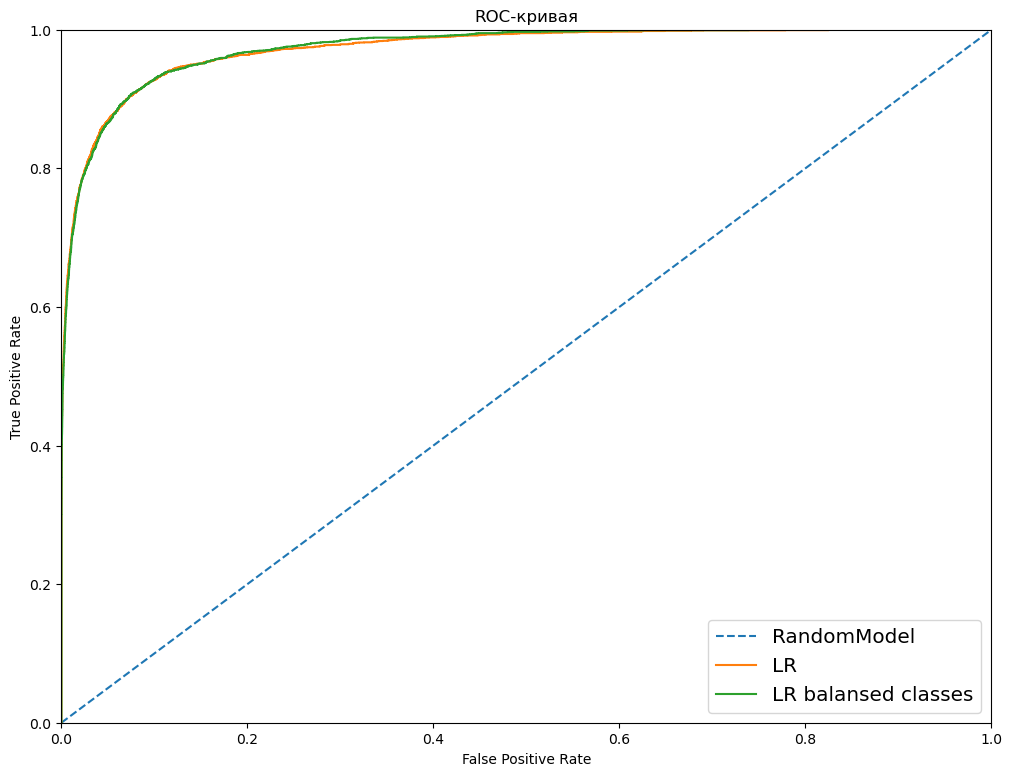

In [13]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


classificator = LogisticRegression()
classificator.fit(features_train, target_train)
probabilities_valid = classificator.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1 = f1_score(target_valid, classificator.predict(features_valid))
plt.plot(fpr, tpr, label='LR')

classificator = LogisticRegression(class_weight='balanced')
classificator.fit(features_train, target_train)
probabilities_valid = classificator.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_balanced = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1_balanced = f1_score(target_valid, classificator.predict(features_valid))
plt.plot(fpr, tpr, label='LR balansed classes')


plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

Также взглянем на цифровые показатели.

In [14]:
index = ['LogisticRegression',
         'LR balansed classes']
data = {'F1 на кроссвалидации':[train_f1,
                    train_f1_balanced],
        'F1 на валидационной выборке':[valid_f1,
                           valid_f1_balanced],
        'AUC-ROC':[auc_roc,
                   auc_roc_balanced]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data

,F1 на кроссвалидации,F1 на валидационной выборке,AUC-ROC
LogisticRegression,0.688645,0.748534,0.972557
LR balansed classes,0.743646,0.754926,0.973539


Как мы видим, показатели f1-метрики лучше при работе со сбалансрованными данными как при кроссвалидации, так и пна валидационной выборке, AUC-ROC также чуть выше по сбалансированным данным.

**Вывод:**
В ходе преподготовки были проведены лемматизация текстов комментариев, получены признаки для обучения, датасет разделен на выборки - обучающую, валидационную и тестовую. На предварительном тестировании оптимальными показателями F1 и AUC-ROC обладает классификатор, где учтен вес классов. В дальнейшем при обучении мы будем использовать сбалансированные данные.

## Обучение

Проведем обучение на трех моделях *LogisticRegression, DecisionTreeClassifier, SGDClassifier*.

Проведем подборку лучшх параметров модели *LogisticRegression* по метрике F1 на кроссвалидации.

In [15]:
%%time

classificator = LogisticRegression()
hyperparams = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 10],
                'class_weight':['balanced']}]


print('# Подборка гиперпараметров по метрике f1')
print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
print("Лучший набор гиперпараметров:")
print()
LR_best_params = clf.best_params_
print(LR_best_params)
print()
print("Сетка оценок f1:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_LR = max(means)

# Подборка гиперпараметров по метрике f1

Лучший набор гиперпараметров:

{'C': 10, 'class_weight': 'balanced', 'solver': 'lbfgs'}

Сетка оценок f1:

0.696010 for {'C': 0.1, 'class_weight': 'balanced', 'solver': 'newton-cg'}
0.696037 for {'C': 0.1, 'class_weight': 'balanced', 'solver': 'lbfgs'}
0.695858 for {'C': 0.1, 'class_weight': 'balanced', 'solver': 'liblinear'}
0.743715 for {'C': 1, 'class_weight': 'balanced', 'solver': 'newton-cg'}
0.743646 for {'C': 1, 'class_weight': 'balanced', 'solver': 'lbfgs'}
0.743680 for {'C': 1, 'class_weight': 'balanced', 'solver': 'liblinear'}
0.759056 for {'C': 10, 'class_weight': 'balanced', 'solver': 'newton-cg'}
0.759366 for {'C': 10, 'class_weight': 'balanced', 'solver': 'lbfgs'}
0.759032 for {'C': 10, 'class_weight': 'balanced', 'solver': 'liblinear'}

Wall time: 44.5 s


Итак, лучшим набором гиперпараметров стали `'C': 10, 'solver': 'lbfgs'`. Теперь поведем обучение модели с данными гиперпараметрами и взглянем на метрику f1 как на кроссвалидации, так и на валидационной выборке.

In [16]:
%%time

classificator = LogisticRegression()
classificator.set_params(**LR_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_LR = f1_score(target_valid, target_predict)
print('F1 на кроссвалидации', cv_f1_LR)
print('F1 на валидационной выборке', valid_f1_LR)

F1 на кроссвалидации 0.7593664162720429
F1 на валидационной выборке 0.7627166808752486
Wall time: 3.31 s


 Как мы видим, показатели f1 на кроссвалидации и валидационной выборке отвечают цели проекта иметь метрику более 0,75.
 
 Теперь проведем подборку лучшх параметров модели DecisionTreeClassifier по метрике F1 на кроссвалидации.

In [17]:
%%time

classificator = DecisionTreeClassifier()
hyperparams = [{'max_depth':[x for x in range(30,51,2)],
                'random_state':[3301],
                'class_weight':['balanced']}]


print('# Подборка гиперпараметров по метрике f1')
print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
print("Лучший набор гиперпараметров:")
print()
DTC_best_params = clf.best_params_
print(DTC_best_params)
print()
print("Сетка оценок f1:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_DTC = max(means)

# Подборка гиперпараметров по метрике f1

Лучший набор гиперпараметров:

{'class_weight': 'balanced', 'max_depth': 34, 'random_state': 3301}

Сетка оценок f1:

0.628300 for {'class_weight': 'balanced', 'max_depth': 30, 'random_state': 3301}
0.627614 for {'class_weight': 'balanced', 'max_depth': 32, 'random_state': 3301}
0.632397 for {'class_weight': 'balanced', 'max_depth': 34, 'random_state': 3301}
0.616270 for {'class_weight': 'balanced', 'max_depth': 36, 'random_state': 3301}
0.617999 for {'class_weight': 'balanced', 'max_depth': 38, 'random_state': 3301}
0.622186 for {'class_weight': 'balanced', 'max_depth': 40, 'random_state': 3301}
0.609663 for {'class_weight': 'balanced', 'max_depth': 42, 'random_state': 3301}
0.611388 for {'class_weight': 'balanced', 'max_depth': 44, 'random_state': 3301}
0.613481 for {'class_weight': 'balanced', 'max_depth': 46, 'random_state': 3301}
0.613702 for {'class_weight': 'balanced', 'max_depth': 48, 'random_state': 3301}
0.613403 for {'class_weight': 

Лучшим гиперпараметром дерева стала его глубина *34*. Проведем обучение данной модели с этим гиперпараметром и посмотрим на метрику f1 на кроссвалидации и валидационной выборке.

In [18]:
%%time

classificator = DecisionTreeClassifier()
classificator.set_params(**DTC_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_DTC = f1_score(target_valid, target_predict)
print('F1 на кроссвалидации', cv_f1_DTC)
print('F1 на валидационной выборке', valid_f1_DTC)

F1 на кроссвалидации 0.6323966641713705
F1 на валидационной выборке 0.652968775279081
Wall time: 23 s


Как мы видим, данная модель не дает нам метрики f1 нужного качества.

Теперь подберем лучшие параметры на кроссвалидации для модели SGDClassifier.

In [19]:
%%time

classificator = SGDClassifier()
hyperparams = [{'loss':['hinge', 'log', 'modified_huber'],
                'learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'],
                'eta0':[0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
                'random_state':[3301],
                'class_weight':['balanced']}]


print('# Подборка гиперпараметров по метрике f1')
print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
print("Лучший набор гиперпараметров:")
print()
SGDC_best_params = clf.best_params_
print(SGDC_best_params)
print()
print("Сетка оценок f1:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_SGDC = max(means)

# Подборка гиперпараметров по метрике f1

Лучший набор гиперпараметров:

{'class_weight': 'balanced', 'eta0': 0.3, 'learning_rate': 'adaptive', 'loss': 'modified_huber', 'random_state': 3301}

Сетка оценок f1:

0.729753 for {'class_weight': 'balanced', 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'hinge', 'random_state': 3301}
0.701867 for {'class_weight': 'balanced', 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'log', 'random_state': 3301}
0.748898 for {'class_weight': 'balanced', 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'modified_huber', 'random_state': 3301}
0.732931 for {'class_weight': 'balanced', 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'hinge', 'random_state': 3301}
0.704473 for {'class_weight': 'balanced', 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'log', 'random_state': 3301}
0.750950 for {'class_weight': 'balanced', 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'modified_huber', 'random_state': 3301}
0.651516 for {'class_weight': 'bal

Лучшими параметрами модели стали *'eta0': 0.3, 'learning_rate': 'adaptive', 'loss': 'modified_huber'*. Обучим модель при данных параметрах и взгялнем на метрику f1 (в том числе на валидационной выборке).

In [20]:
%%time

classificator = SGDClassifier()
classificator.set_params(**SGDC_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_SGDC = f1_score(target_valid, target_predict)
print('F1 на кроссвалидации', cv_f1_SGDC)
print('F1 на валидациионной выборке', valid_f1_SGDC)

F1 на кроссвалидации 0.7523921500293165
F1 на валидациионной выборке 0.7576374745417515
Wall time: 1.95 s


Мы видим, что модель SGDClassifier также дала приемлимые для цели проекта результаты. Но давайте сравним полученные значения метрики f1 обученных нами моделей, чтобы выбрать лучшую.

In [21]:
index = ['LogisticRegression',
         'DecisionTreeClassifier',
         'SGDClassifier']
data = {'F1 на кроссвалидации':[cv_f1_LR,
                    cv_f1_DTC,
                    cv_f1_SGDC],
        'F1 на валидационной выборке':[valid_f1_LR,
                           valid_f1_DTC,
                           valid_f1_SGDC]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Выполнение задачи'] = scores_data['F1 на валидационной выборке'] > 0.75
scores_data

,F1 на кроссвалидации,F1 на валидационной выборке,Выполнение задачи
LogisticRegression,0.759366,0.762717,True
DecisionTreeClassifier,0.632397,0.652969,False
SGDClassifier,0.752392,0.757637,True


Как мы видим, лучшие показатели метрики F1 дала модель LogisticRegression как на кроссвалидации, так и на валидационной выборке. В дальнейшем проверим именно эту модель на тестовой выборке и сделаем выводы. 

**Вывод:**
Лучшие показатели метрики F1 дала модель LogisticRegression как на кроссвалидации *(f1 = 0.759366)*, так и на валидационной выборке *(f1 = 0.762717)*.


## Выводы

Проверим лучшую модель по результатам обучения на тестовой выборке, а также взглянем на показатель метрики f1 и на другие метрики.

Метрики LogisticRegression
F1: 0.7666666666666665
Precision: 0.7143239625167336
Recall: 0.8272868217054263
Accuracy: 0.9490253931385166
ROC AUC: 0.9659006829307382



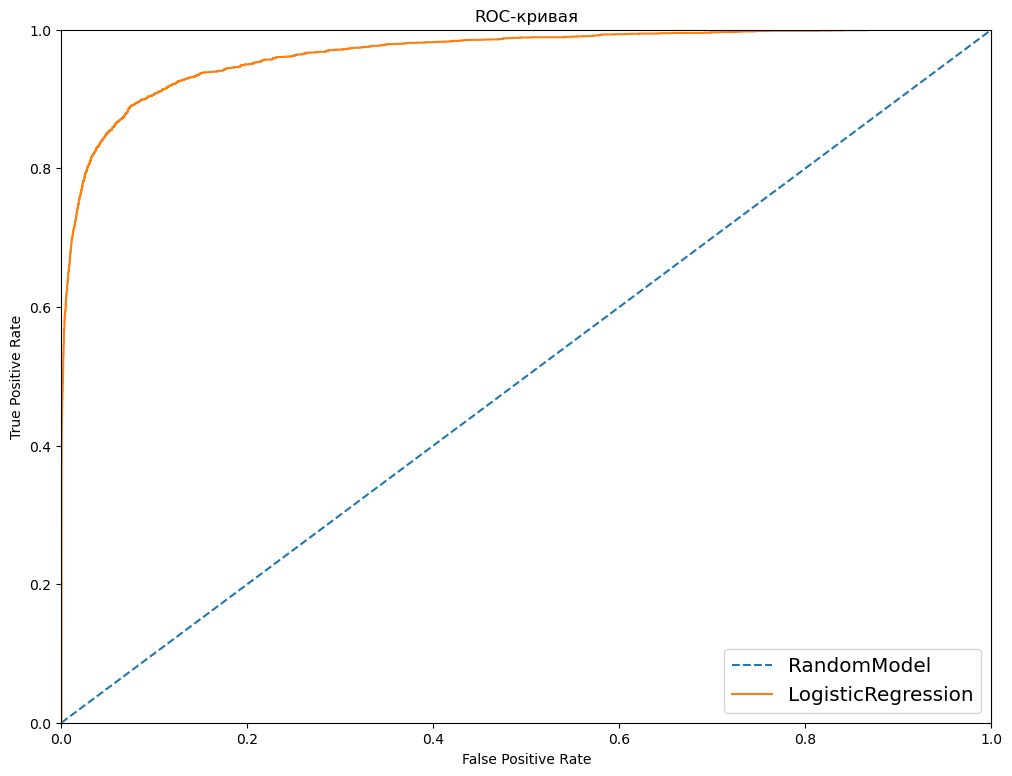

In [22]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


classificator = LogisticRegression()
classificator.set_params(**LR_best_params)
classificator.fit(features_train, target_train)
probabilities_test = classificator.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = classificator.predict(features_test)
plt.plot(fpr, tpr, label='LogisticRegression')
print('Метрики LogisticRegression')
print('F1:', f1_score(target_test, predict_test))
print('Precision:', precision_score(target_test, predict_test))
print('Recall:', recall_score(target_test, predict_test))
print('Accuracy:', accuracy_score(target_test, predict_test))
print('ROC AUC:', roc_auc_score(target_test, probabilities_one_test))
print()

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

**Вывод:** Модель LogisticRegression показала небходимый результат на тестовой выборке.

**Общие выводы:**

В ходе работы над проектом было сделано:

- Подготовленны данные для обучения на моделях (лемматизация).
- Определена необходимость балансировки классов.
- Датасет поделен на обучающую, валидационную и тестовою выборку.
- Обучены модели и выбрана лучшая из них на валидационной выборке.
- Проведена проверка выбранной лучшей модели на тестовой выборке и определены ряд ее показателей, в том числе f1.

Лучшией моделю стала LogisticRegression. На тестовой выбоке по метрике F1 модель LogisticRegression показала результат *0.7666666666666665*. Цель достигнута. Данная модель обладает достаточно большим показателем Accuracy, что говорит, что модель хорошо находит токсичные комментарии.